Investigation 1: This model is written in Keras with tensorflow backend. Keras is faster for initial work. And easier to read 
but not as granualar as pure tensorflow the idea is to move to full tensor flow once we have a working model. 

The model takes in a list of uuids 
creates integer dictionarys for them 
zero pads them to the appropiate size.

The model takes in the n-1 observations and the target is the nth uuid.
    

In [11]:
from keras import callbacks
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, TimeDistributed
from keras import optimizers
import matplotlib.pyplot as plt
import pickle
import re
import pandas as pd
import numpy as np
import zipfile
import gzip

##################### Read in Data  #####################

In [16]:
# NO NEED TO RUN THIS CELL. I have pickled the data 

# Reads in data and produces a dataframe df 
file_loc ='data/CustomerActions-Movies-TimedUUID-3days.csv.zip'
def readData(file_loc):
    data_dict={}
    max_steps=0
    lines_list=[]
    with zipfile.ZipFile(file_loc, 'r') as z:
        with z.open(z.namelist()[0]) as f:
            for line in f:
                line2= re.split(",|~|\\n|\\n'",str(line).replace("\\n'",'\n').strip())
                lines_list.append(line2)
                if len(line2)>max_steps:
                    max_steps=len(line2)           
        for i,v in enumerate(lines_list):   
            lis2 = list(filter(None, v))
            data_dict[i]= lis2 + [0]* (max_steps-len(lis2))
        df= pd.DataFrame(data_dict).T
        return data_dict,df,max_steps
data_dict,df,max_steps = readData(file_loc)

View dataframe 

In [13]:
# df has dimensions (506548, 75)
df.to_pickle('data/3days_df.gzip','gzip')
temp= gzip.open('data/3days_df.pkl')
df=pd.read_pickle(temp)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,b'32B0630488554327,1509559350,93d8663c-404f-4877-a665-c8797d8ae8e5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,b'32B0630488568972,1509572912,9ab4430a-5a6b-4d00-804e-74634be17a74,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,b'32B0630488568974,1509462399,57f7fffe-1c02-4a73-90ed-1c46bde8c3e6,1509540077,edbf9d69-80ac-4b62-95a8-665792899168,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,b'32C0050489325572,1509394813,25163878-7573-4779-9b2e-63fda24ac838,1509574002,c1d1dcef-9552-4fb8-b812-ec7455b67c7e,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,b'32C0060489462801,1509554398,b79710af-5540-49f5-993f-35c3235740e1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##################### PreProcessing  #####################

Lets take only the uuids

In [7]:
only_uuids = df.loc[:,::2] #select only uuid 
only_timestamps = df.loc[:,1::2]  #select only timestamp 

Create a dictionary so each uuid has a unique id and a reverse dictionary so we can give an id and get the uuid back

In [8]:
set_uuid = set([])
for i in range(2,max_steps,2): #start from 2 because 1 is the device id 
    set_uuid.update(only_uuids.loc[:,i])

vocab_size = len(set_uuid) #length of vocabulary
dictionary={}  # uuid:int
reversed_dictionary={}  #int:uuid
# convert uuid to numbers 
for i,value in enumerate(set_uuid):
    reversed_dictionary[i] = value
    dictionary[value]=i


In [9]:
reversed_dictionary[1]

'667e6bc0-961c-4a8a-9a55-7e2862d668ea'

##################### Data Filtering  #####################

Here we subset the data by how many movies a particular customer has watched and convert it to a matrix.
We don't use the device id currently

In [12]:
watched_more = 4
watched_less =len(only_uuids.columns)
four_or_more = only_uuids.loc[(np.sum(only_uuids!=0,axis=1)>watched_more) & (np.sum(only_uuids!=0,axis=1)<watched_less),:]
four_or_more=four_or_more.loc[:,2:].as_matrix() #0 is device id

In [17]:
# We have about 74k observations
four_or_more.shape


76

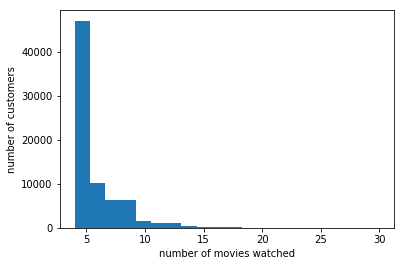

In [21]:
n_views=(four_or_more != 0).astype(int).sum(axis=1)
plt.hist(n_views,bins=20)
plt.xlabel('number of movies watched')
plt.ylabel('number of customers')
plt.show()

We need to convert all the uuid into ids using the dictionary we created 

In [24]:
# integer encode input data
input_encoded_all=[]
for i in range(len(four_or_more)):
    input_encoded_all.append(list(filter(lambda x: x!=0 ,[dictionary[uuid] for uuid in four_or_more[i]])))

 
#pad sequences
max_len = max([len(seq) for seq in input_encoded_all])
padded_data = pad_sequences(input_encoded_all,maxlen=max_len,padding='pre')

In [26]:
# input_encoded_all is an array of list, where each list is a customer watch history
input_encoded_all[:4]

[[1494, 1494, 1494, 1494],
 [5102, 5284, 4271, 7040],
 [5086, 2457, 4966, 3962],
 [3901, 8169, 4735, 5343, 6175, 6374]]

In [28]:
# padded_data is the input data but just padded with preceeding zeros to the max length of watches
padded_data[:4]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 1494, 1494, 1494, 1494],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 5102, 5284, 4271, 7040],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 5086, 2457, 4966, 3962],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 3901, 8169, 4735, 5343, 6175, 6374]], dtype=int32)

##################### Batch generation  #####################

In [31]:
# num_steps is the number of 'timesteps'. I have put timestep in qoutes because the timesteps are not evenly spaced 
# This generator will generate a training batch for the model

num_steps=max_len-1

def generate(pad_data,batch_size,num_steps):
    x = np.zeros((batch_size, num_steps))
    y = np.zeros((batch_size,num_steps,vocab_size))
    current_idx=0
    data_len= len(pad_data[current_idx])
    while True:
        for i in range(batch_size):
            x[i, :] = pad_data[i][:-1]
            temp_y = pad_data[i][1:]
            # convert all of temp_y into a one hot representation
            y[i, :,:] = to_categorical(temp_y, num_classes=vocab_size)
        yield x, y

##################### LSTM model #####################

In [33]:
hidden_size=300 #number of hidden nodes in LSTM blocks (i.e. number of nodes for the input, forget and output gates )
batch_size =50


model = Sequential() #initialise a sequential model
model.add(Embedding(vocab_size, hidden_size, input_length=num_steps)) #put the uuid into a vector representation with length equal to the number of hidden nodes
model.add(LSTM(hidden_size, return_sequences=True)) # first lstm layer, we return all nodes output
model.add(LSTM(hidden_size,return_sequences=True)) 
model.add(Dropout(0.5)) 
model.add(LSTM(hidden_size, return_sequences=True)) # last lstm layer, we return (all nodes output) this is optionally but I think its benefial. We can discus?
model.add(TimeDistributed(Dense(vocab_size))) # apply a fully connected nn to each output 
model.add(Activation('softmax')) #logits --> probs 


In [34]:
# compile the model 
model.compile(loss='categorical_crossentropy', optimizer='adam' ,metrics=['categorical_accuracy'])

In [35]:
# train the model 
# I have subset the data even more to just 5000 samples just for quicker iterations
# and validation is 200 samples 
model.fit_generator(generate(padded_data[:5000],batch_size,num_steps), 5000//(batch_size), 50,
                    validation_data=generate(padded_data[5000:5200],batch_size,num_steps),
                        validation_steps=200//batch_size)


Epoch 1/50
100/100 [==============================] - 187s 2s/step - loss: 2.0985 - categorical_accuracy: 0.8180 - val_loss: 2.4931 - val_categorical_accuracy: 0.8117
Epoch 2/50
  8/100 [=>............................] - ETA: 2:51 - loss: 1.3330 - categorical_accuracy: 0.8262

KeyboardInterrupt: 

In [ ]:
# The high accuracy is decietful because most of the data are zeros so the accuracy will be high if it learns to predict zeros 
# but the last output( which we are interested in is wrong)

In [ ]:
##################### Predictions #####################

In [41]:
# number of predictions wanted 
num_predict = 2

true_print_out = []
pred_print_out = []
for i in range(num_predict):
    data = next(generate(padded_data[:10],1,num_steps), 1)
    prediction = model.predict(data[0])
    actual = data[1][0]
    predict_idx = np.argmax(prediction[:, -1, :])
    actual = np.argmax(actual[num_steps-1, :])
    true_print_out.append(reversed_dictionary[actual])
    pred_print_out.append(reversed_dictionary[predict_idx])
print('actual :',true_print_out)
print('predicted :',pred_print_out)

actual : ['ea1f7105-f2a6-444d-998c-c72dd8f76fa0', 'ea1f7105-f2a6-444d-998c-c72dd8f76fa0']
predicted : [0, 0]
